<a href="https://colab.research.google.com/github/KristinaBorovikS/ML/blob/main/HW4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

Validation Loss: 0.19
Accuracy Score gradbusting: 0.81

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.62      1.00      0.76        84
     british       0.70      0.99      0.82       157
cajun_creole       0.75      1.00      0.86       328
     chinese       0.82      0.99      0.90       510
    filipino       0.62      0.88      0.73       136
      french       0.65      0.93      0.77       550
       greek       0.69      0.93      0.79       249
      indian       0.81      0.92      0.86       602
       irish       0.73      0.76      0.74       151
     italian       0.82      0.85      0.84      1567
    jamaican       0.78      0.78      0.78        91
    japanese       0.80      0.69      0.74       284
      korean       0.90      0.72      0.80       166
     mexican       0.90      0.85      0.87      1336
    moroccan       0.93      0.58      0.72       166
     russian       0.72      0.47      0.57        89
 s

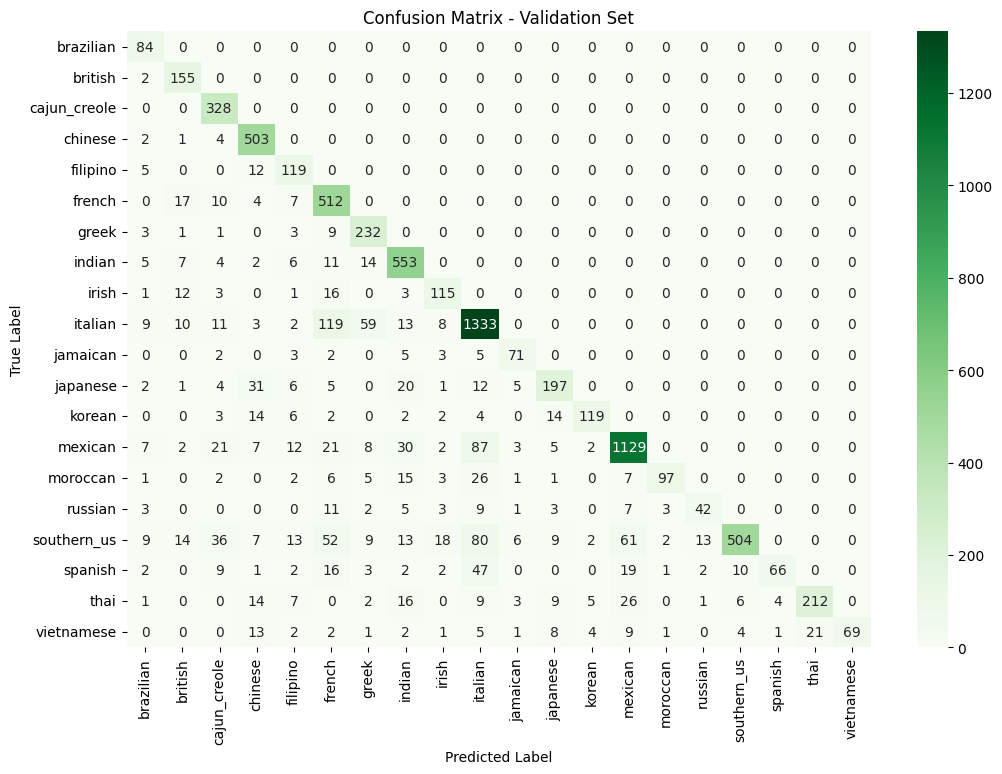

In [4]:
!pip install --quiet optuna

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
import warnings

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())
print(df['cuisine'].value_counts())
df_new=df['ingredients']
print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
    X_val_vectorized = vectorizer.transform(X_val)

    from sklearn.neighbors import KNeighborsClassifier
    n_neighbors = trial.suggest_int("n_neighbors", 2, 15)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train_vectorized, df['cuisine'])

    val_predictions = model.predict(X_val_vectorized)

    val_losses = model.score(X_val_vectorized, y_val)
    accuracy = accuracy_score(y_val, val_predictions)
    return accuracy


pruner = optuna.pruners.MedianPruner()
optuna.logging.disable_default_handler()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

import optuna.visualization as vis


fig1=vis.plot_optimization_history(study)
fig1.show()
fig2=vis.plot_param_importances(study)
fig2.show()
fig3=vis.plot_slice(study)
fig3.show()

X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=study.best_params['n_neighbors'])
model.fit(X_train_vectorized, df['cuisine'])
val_predictions = model.predict(X_val_vectorized)
val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Модель kNN неплохо делает предсказания , однако в некоторых классах проседает recall

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

Validation Loss: 0.20
Accuracy Score gradbusting: 0.80

Classification Report:
              precision    recall  f1-score   support

   brazilian       1.00      0.45      0.62        84
     british       1.00      0.25      0.41       157
cajun_creole       1.00      0.76      0.86       328
     chinese       0.85      0.94      0.89       510
    filipino       1.00      0.29      0.45       136
      french       0.96      0.49      0.65       550
       greek       0.98      0.59      0.74       249
      indian       0.97      0.91      0.94       602
       irish       1.00      0.27      0.43       151
     italian       0.61      0.99      0.76      1567
    jamaican       1.00      0.57      0.73        91
    japanese       1.00      0.76      0.86       284
      korean       0.99      0.72      0.84       166
     mexican       0.91      0.95      0.93      1336
    moroccan       1.00      0.73      0.84       166
     russian       1.00      0.36      0.53        89
 s

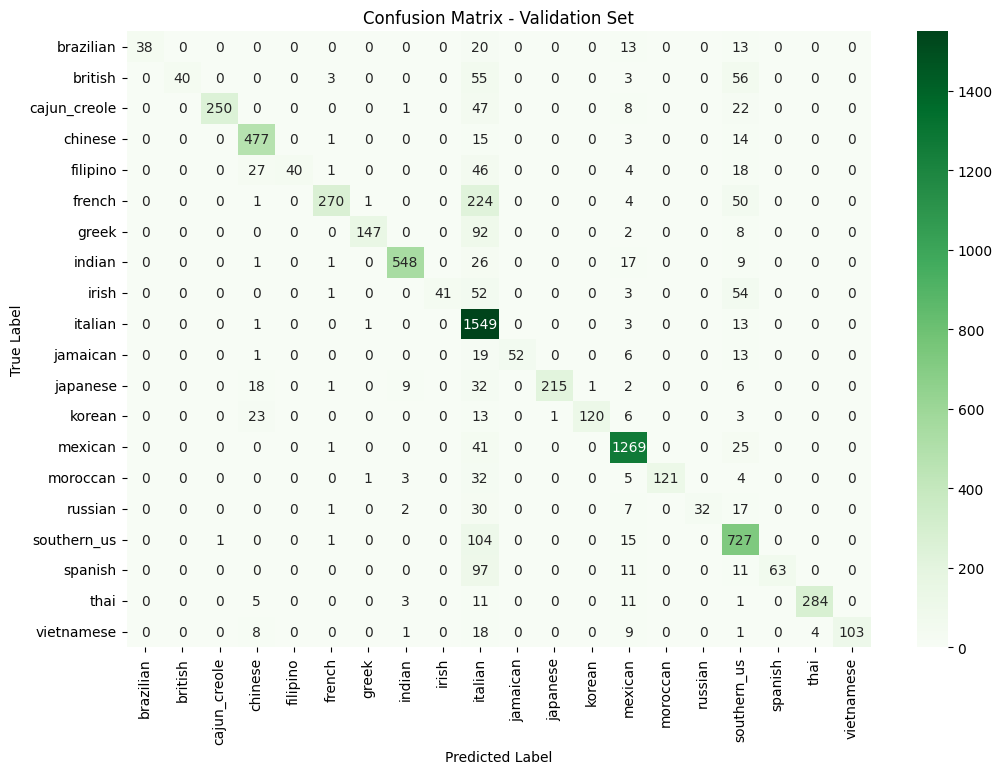

In [5]:

!pip install optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train
print(df.head())
print(df.info())
print(df['cuisine'].value_counts())
df_new=df['ingredients']
print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
    X_val_vectorized = vectorizer.transform(X_val)

    from sklearn.ensemble import ExtraTreesClassifier
    n_estimators = trial.suggest_int("n_estimators", 200, 400)
    max_depth = trial.suggest_int("max_depth", 25,30)
    model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0,class_weight='balanced')
    model.fit(X_train_vectorized, df['cuisine'])

    val_predictions = model.predict(X_val_vectorized)

    val_losses = model.score(X_val_vectorized, y_val)
    accuracy = accuracy_score(y_val, val_predictions)
    return accuracy


pruner = optuna.pruners.MedianPruner()
optuna.logging.disable_default_handler()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

import optuna.visualization as vis


fig1=vis.plot_optimization_history(study)
fig1.show()
fig2=vis.plot_param_importances(study)
fig2.show()
fig3=vis.plot_slice(study)
fig3.show()


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=study.best_params['n_estimators'], max_depth=study.best_params['max_depth'], random_state=0)
model.fit(X_train_vectorized, df['cuisine'])
val_predictions = model.predict(X_val_vectorized)
val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()






несмотря на class weight , модель все равно смещена в сторону итальянской кухни,у нее низкий precision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00
Validation Loss: 0.22
Accuracy Score gradbusting: 0.78

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.83      0.54      0.65        84
     british       0.82      0.39      0.53       157
cajun_creole       0.83      0.69      0.75       328
     chinese       0.76      0.87      0.81       510
    filipino       0.76      0.45      0.56       136
      french       0.65      0.63      0.64       550
       greek       0.83      0.66      0.73       249
      indian       0.85      0.87      0.86       602
       irish       0.72      0.46      0.56       151
     italian       0.76      0.92      0.84      1567
    jamaican       0.92      0.59      0.72        91
    japanese       0.86      0.68      0.76       284
      korean       0.90      0.69      0.78       166
     mexican       0.88      0.93      0.90      1336
    moroccan       0.90      0.7

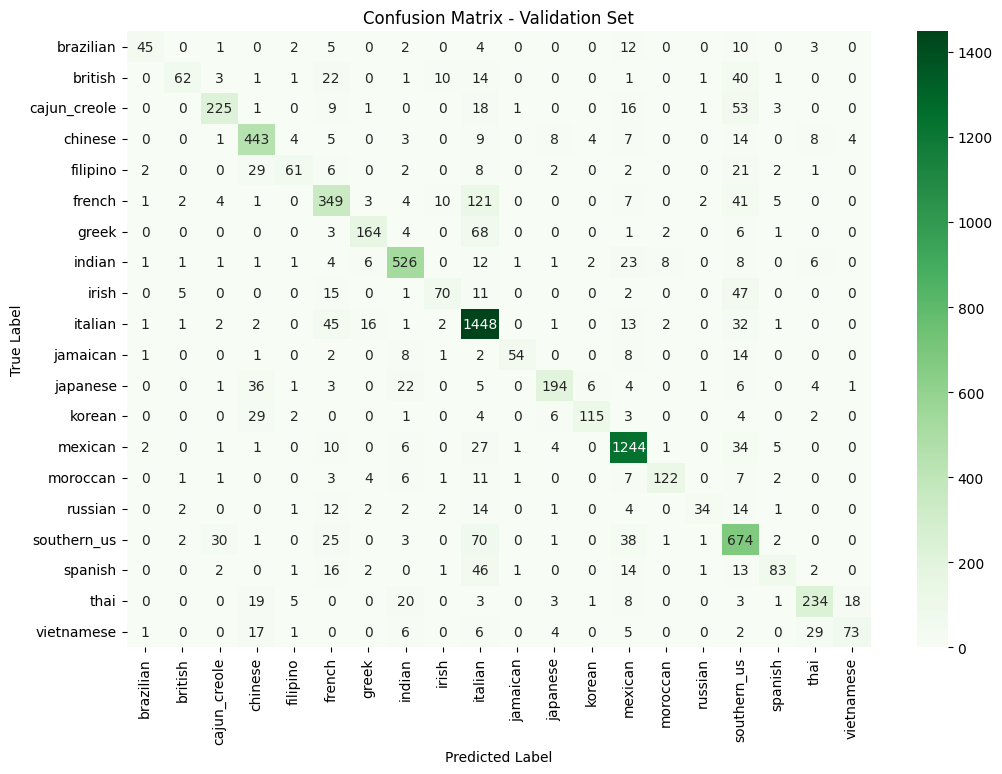

In [ ]:
!pip install catboost
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score




combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]
X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

модель дает похожие результаты с Extra Trees , однако precision у итальянской кухни лучше чем в Extra Trees, но проседает французская

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

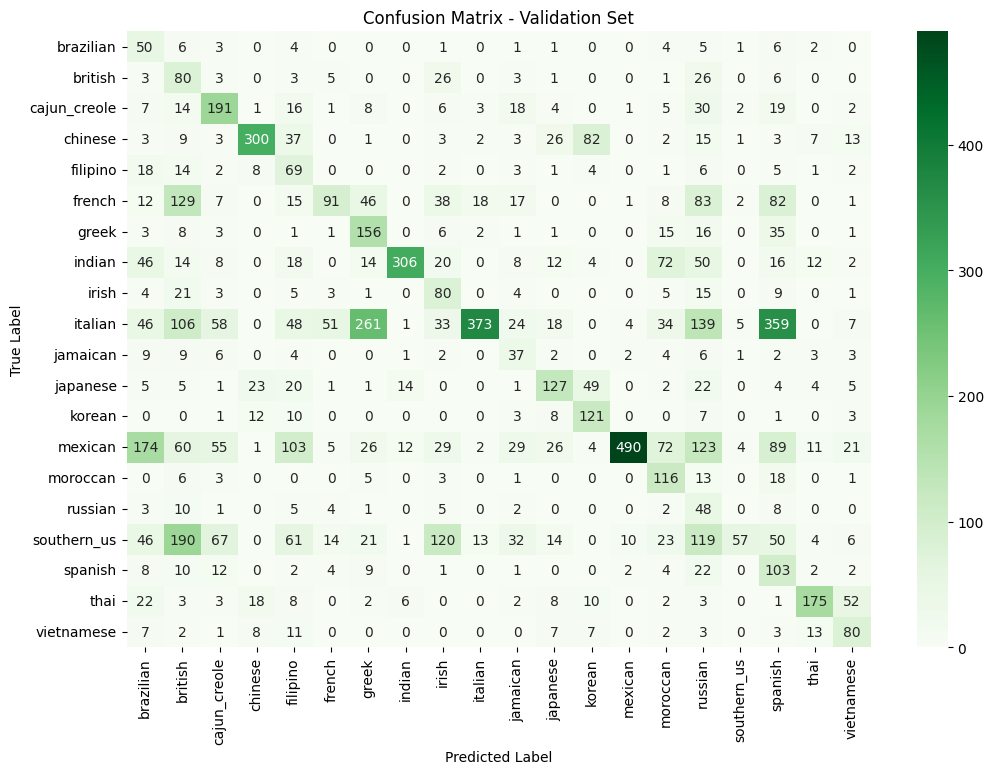

In [14]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]
oversample = SMOTE()
X, y= oversample.fit_resample(X_train_vectorized, df['cuisine'])

X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model = QuadraticDiscriminantAnalysis(reg_param=0.7,store_covariance=True, tol=0.01)
model.fit(X.toarray(), y)

val_predictions = model.predict(X_val_vectorized.toarray())


val_losses = model.score(X_val_vectorized.toarray(), y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

несмотря на оверсемплирование , результаты средние

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

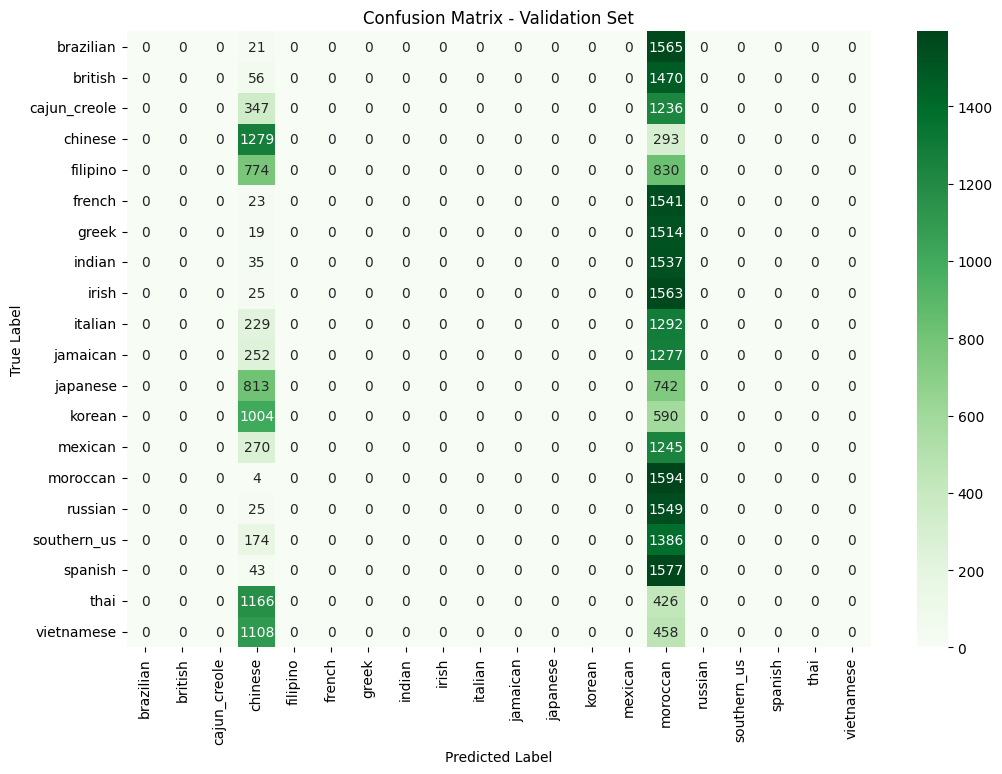

In [9]:

from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

import numpy as np

from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]

oversample = SMOTE()
X, y= oversample.fit_resample(X_train_vectorized, df['cuisine'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_vectorized = X_val

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(estimator=tree.DecisionTreeClassifier(max_depth=1),n_estimators=150,learning_rate=0.001, random_state=0)
model.fit(X, y)

val_predictions = model.predict(X_val_vectorized)


val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions,zero_division=0)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

несмотря на оверсемплированнее , модель имеет очень плохую метрику и нам не подходит


      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

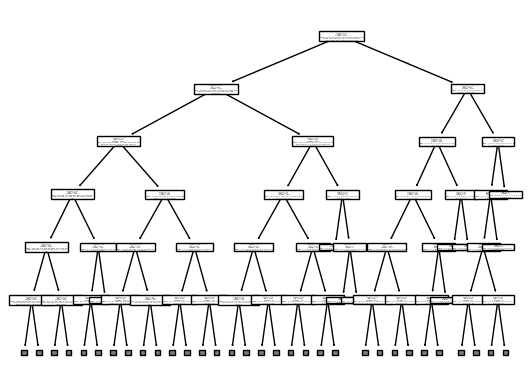

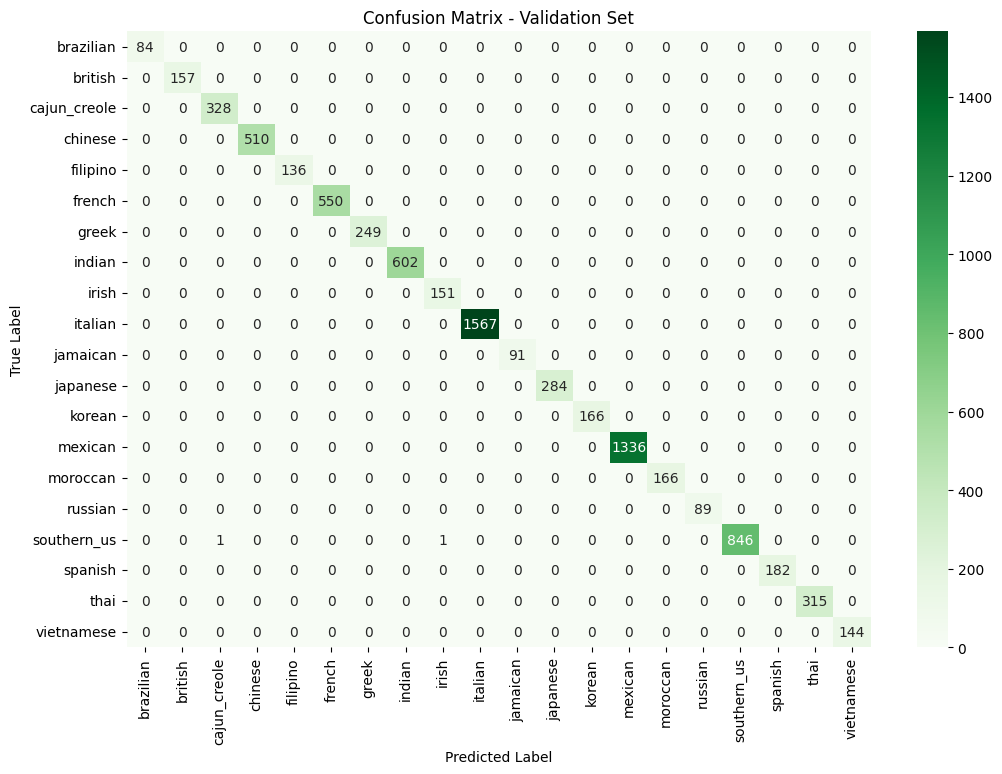

In [10]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn import tree

model = tree.DecisionTreeClassifier()
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)
tree.plot_tree(model,max_depth=5)
print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

модель дерева переобучилась

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

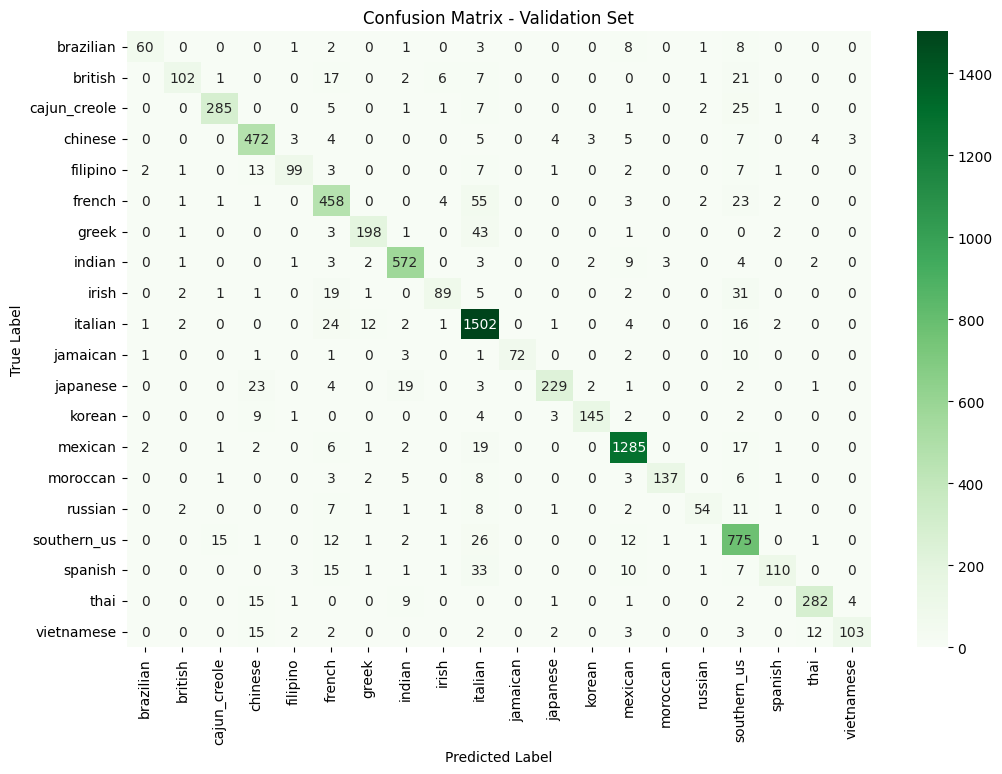

In [ ]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


from sklearn import svm

model = svm.SVC()
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Модель имеет лучшую метрику из всех ранее представленных , ее возьмем за основу и попытаемся улучшить метрики

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

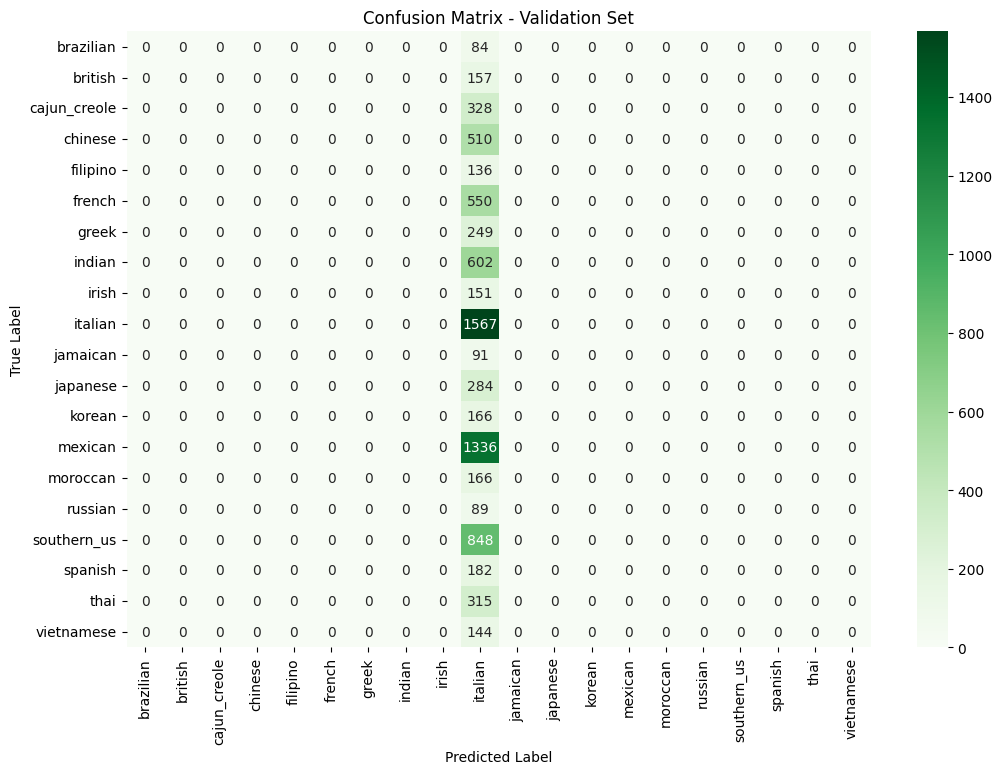

In [7]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy="most_frequent")
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)


val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions,zero_division=0)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

модель предсказывает самый частый класс

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

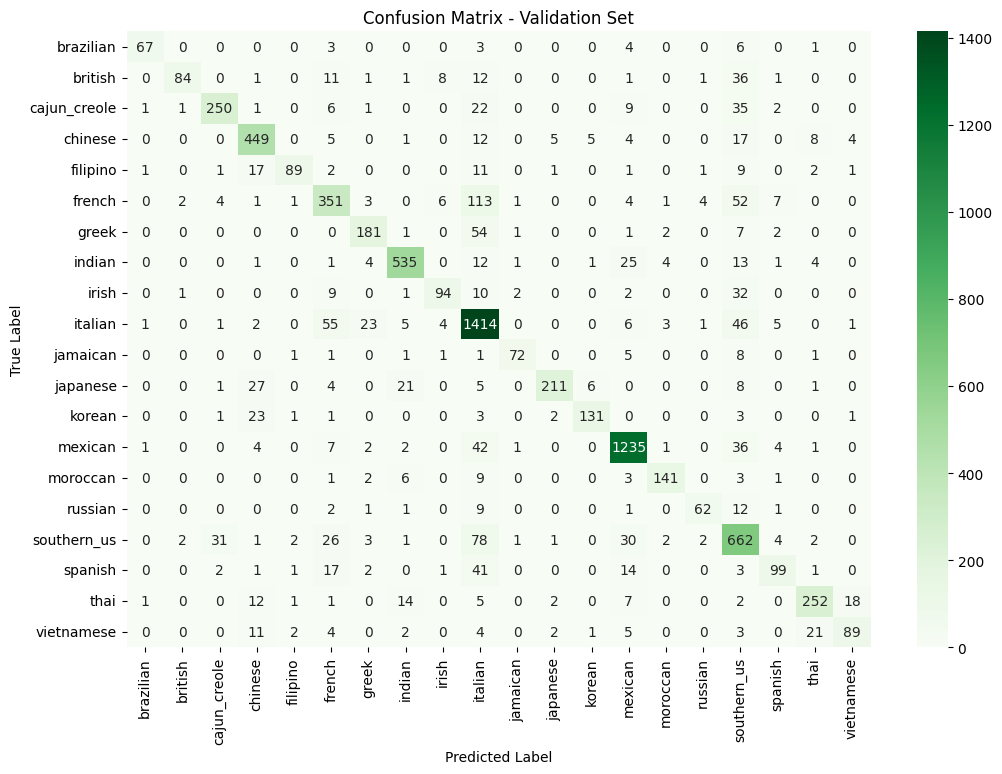

In [ ]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)



from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Имеет неплохую метрику , есть небольшое смещение в сторону итальянской кухни , французкая кухня предсказывается плохо

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

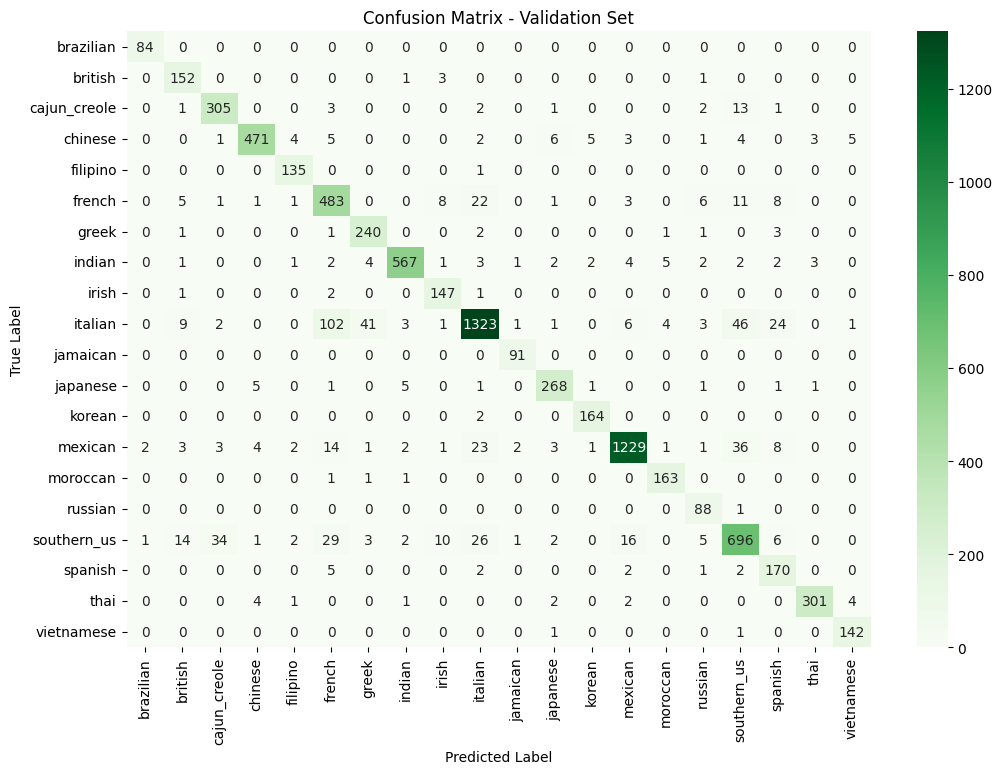

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
train = pd.read_json(r'train.json')
test = pd.read_json(r'test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())

count =0
count_in=0
df_new=df['ingredients'].copy()
for i in df['ingredients']:
    count_in=0
    i_new=i
    for x in i :
        x=x.replace(" ","")
        i_new[count_in]=x
        if(count_in<len(i_new)):
           count_in= count_in +1
    i_new.sort()
    df_new[count]=i_new
    if (count< len(df_new)):
        count =count +1

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


model = SVC( kernel='rbf',class_weight='balanced', random_state=111, verbose=True)
model.fit(X_train_vectorized, df['cuisine'])

from sklearn.frozen import FrozenEstimator
calibrator = CalibratedClassifierCV(FrozenEstimator(model),method='isotonic')
calibrator.fit(X_train_vectorized, df['cuisine'])

val_predictions = calibrator.predict(X_val_vectorized)



val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


   Видим , что с лучшим препроцессингом данных , весами для классов и калибровкой модель опорных векторов дает лучшие результаты

